## 1. A naive analysis

In [597]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn import linear_model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [604]:
df0 = pd.read_csv("lalonde.csv", index_col='id')

df0['no degree'] = df0['nodegree']
df0 = df0.drop('nodegree', 1)
for col in ['black', 'hispan', 'married', 'no degree']:
    df0[col] = df0[col].map(lambda x: col if x == 1 else np.nan)
df0['black'].fillna(df0['hispan'], inplace=True)
df0['black'].fillna('white', inplace=True)
df0['race'] = pd.Categorical(df0['black'])
df0['married'].fillna('bachelor', inplace=True)
df0['married'] = pd.Categorical(df0['married'])
df0['no degree'].fillna('graduate', inplace=True)
df0['no degree'] = pd.Categorical(df0['no degree'])
df0 = df0.drop(['black', 'hispan'], 1)

# It is unrealistic that a worker has 0 salary
df0 = df0[(df0['re78'] > 0) | (df0['re74'] > 0) | (df0['re75'] > 0)]
df = df0[df0['re78'] > 0]

In [848]:
len(df0.index.unique())

559

In [3]:
len(df)

471

In [606]:
control = df[df['treat'] == 0].drop('treat', 1)
treat = df[df['treat'] == 1].drop('treat', 1)

 The data is not normally distributed since it's asymmetric. It is however positively skewed as shown in the boxplot and histograms. The QQ plots show a significant deviation from normality in the right tail (and also in the left tail, but that is trivial because the salary cannot be negative). This might hint to a power law since it is rare that workers have very high salaries but not so rare. Indeed, the log-log plots show some decreasing slope. Also, we noticed that the control group is more than twice than the treatment group

By comparison, we observe that the training has been mostly effective with workers with medium wage (< 2000). Indeed, the average salary increased of around 21%, from around 930 to 1150. In a similar fashion, medium-high salaries (between 2000 and 4500) experienced a 10% increment. The treatment was less effective with higher salaries. This analysis already hints to biases in both treatment and control groups: the histograms below show "a bump" in the range 5000-1000 of the control group, which is not present in the treatment histogram, as if the treatment reduced the salaries in that range. In contrast, it is reasonable to suspect that the treatment groups is biased towards workers in that range. 

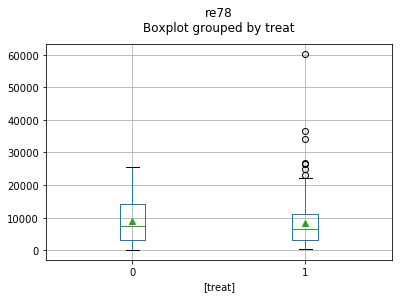

In [551]:
def boxplots(df, attr):
    proc_df = df[df[attr] > 0]
    ax = proc_df[['treat', attr]].boxplot(by='treat', showmeans=True)
    ttl = ax.title
    ttl.set_position([.5, 1.1])

boxplots(df, 're78')

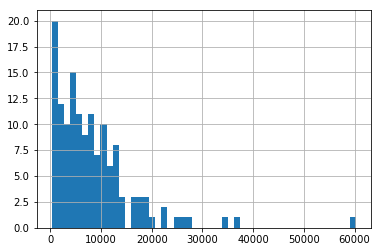

In [824]:
treat['re78'].hist(bins=50)

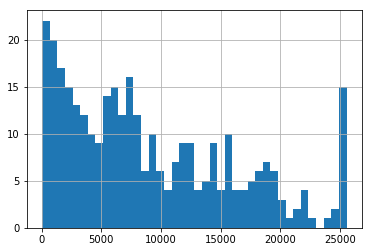

In [815]:
control['re78'].hist(bins=40)

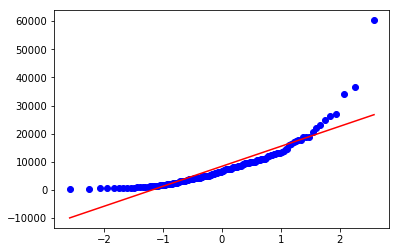

In [554]:
stats.probplot(treat['re78'], dist="norm", plot=matplotlib.pyplot)
plt.show()

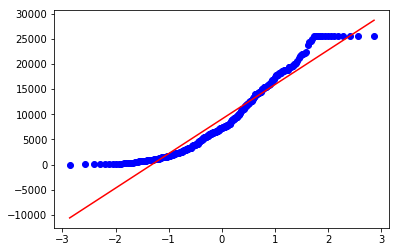

In [555]:
stats.probplot(control['re78'], dist="norm", plot=matplotlib.pyplot)
plt.show()

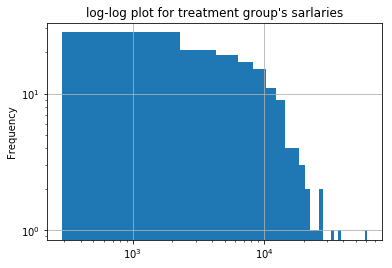

In [639]:
treat['re78'].plot(kind="hist", loglog=True, grid=True, bins=30, title="log-log plot for treatment group's sarlaries")

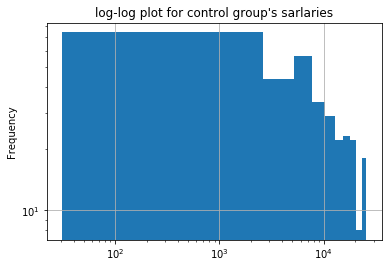

In [636]:
control['re78'].plot(kind="hist", loglog=True, grid=True, title="log-log plot for control group's sarlaries")

In [556]:
control[['re78']].describe()

,re78
count,331.000000
mean,9051.990391
std,7087.340468
min,31.032260
25%,2978.358000
50%,7310.313000
75%,14131.500000
max,25564.670000


In [557]:
treat[['re78']].describe()

,re78
count,140.000000
mean,8389.939665
std,8042.944693
min,289.789900
25%,3167.353750
50%,6504.144500
75%,11017.730000
max,60307.930000


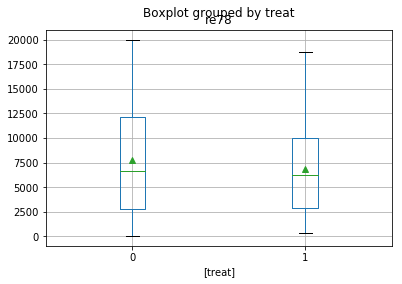

In [921]:
# An effect of the treatment is shown only when limiting the salaries to a lower range
df[df['re78'] < 2000][['treat', 're78']].boxplot(by='treat', showmeans=True)

## 2. A closer look at the data

As shown in the boxplots, the distribution of each feature is similar for both groups (with the exception of 'age', for which the treatment group has a slighlty lower average). This reflects the fact that subjects were offered a job training experience randomly. The histograms show that the salaries and the age are skewed distributions, indeed their qq-plots are arched with respect to the normal distribution. However, the feature 'education' seems to be close to a normal distribution on the other hand.

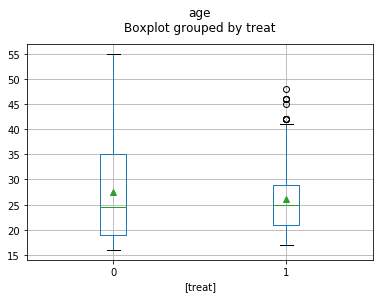

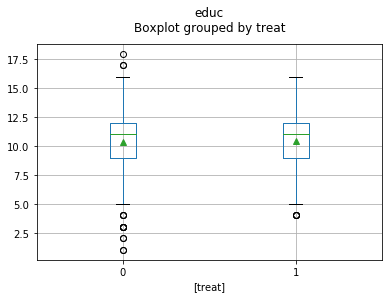

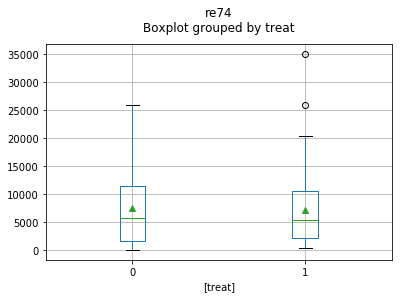

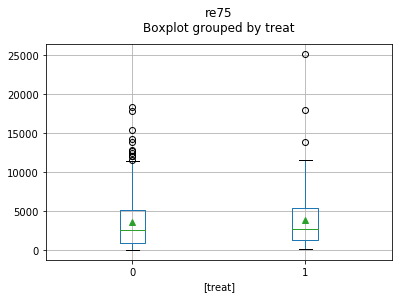

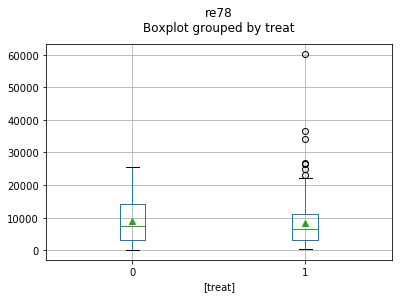

In [971]:
df = df0[['treat', 'age', 'educ', 're74', 're75', 're78']]
treat = df[df['treat'] == 1].drop('treat', 1)
control = df[df['treat'] == 0].drop('treat', 1)
for col in df.drop('treat', 1).columns:
    boxplots(df, col)

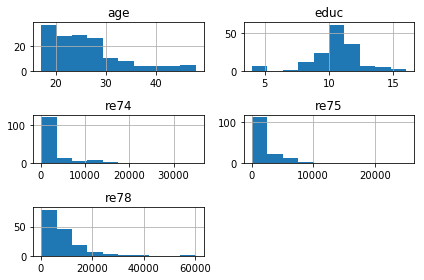

In [953]:
treat.hist()
plt.tight_layout()

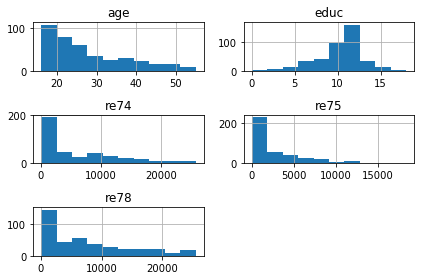

In [954]:
control.hist()
plt.tight_layout()

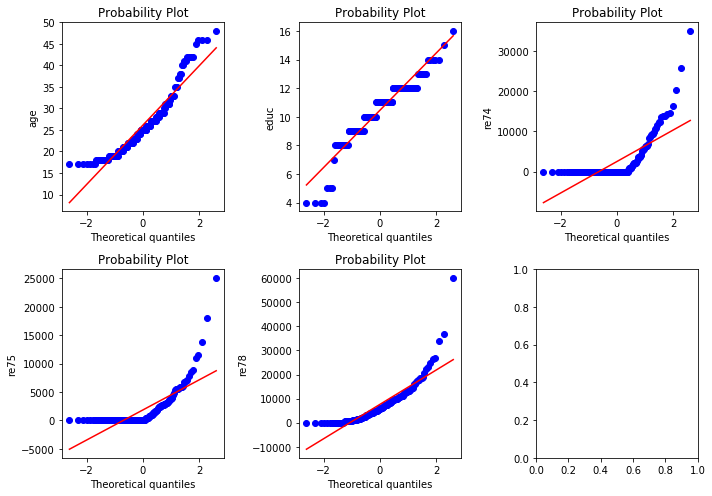

In [955]:
def qqPlots(df):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
    i = 0
    for col in df.columns:
        stats.probplot(df[col], dist="norm", plot=axes[i // 3, i % 3])
        axes[i // 3, i % 3].set_ylabel(col)
        i += 1
    plt.tight_layout()
    plt.show()

qqPlots(treat)

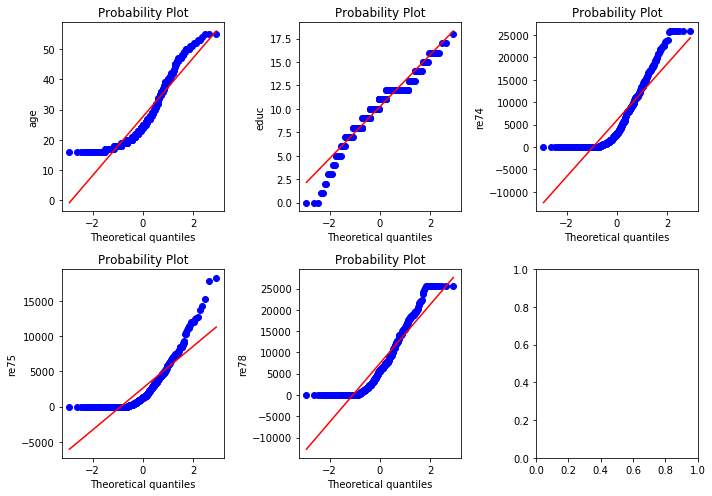

In [956]:
qqPlots(control)

In [957]:
def describeDF(df):
    desc = pd.DataFrame()
    desc['educ'] = df['educ'].describe()
    for col in df.drop('educ', 1):
        desc[col] = df[df[col] > 0][col].describe()
    return desc

describeDF(treat)

,educ,age,re74,re75,re78
count,155.000000,155.000000,54.000000,74.000000,140.000000
mean,10.451613,26.103226,7179.280230,3830.138284,8389.939665
std,2.058222,7.146132,6761.279396,4147.208703,8042.944693
min,4.000000,17.000000,445.170400,74.343450,289.789900
25%,9.000000,21.000000,2155.779000,1228.986750,3167.353750
50%,11.000000,25.000000,5465.396500,2710.460000,6504.144500
75%,12.000000,29.000000,10474.869250,5428.879500,11017.730000
max,16.000000,48.000000,35040.070000,25142.240000,60307.930000


In [958]:
describeDF(control)

,educ,age,re74,re75,re78
count,404.000000,404.000000,317.000000,295.000000,331.000000
mean,10.230198,27.606436,7604.581897,3586.853648,9051.990391
std,2.826493,10.263818,6875.777757,3427.009132,7087.340468
min,0.000000,16.000000,33.307540,10.741940,31.032260
25%,9.000000,19.000000,1579.169000,963.193550,2978.358000
50%,11.000000,24.500000,5683.833000,2565.532000,7310.313000
75%,12.000000,35.000000,11516.570000,5177.613000,14131.500000
max,18.000000,55.000000,25862.320000,18347.230000,25564.670000


In [969]:
df = df0[['treat', 'race', 'married', 'no degree']]
treat = df[df['treat'] == 1].drop('treat', 1)
control = df[df['treat'] == 0].drop('treat', 1)

However, from the analysis of categorical data it emerged that the observational study cannot be considered a 'natural experiment': it seems that black people were more likely to be treated, since they form approximately 80% of the treatment group. Conversely, the control group is composed of over 67% of white people. This confirms what we observed in the naive analysis: the treatment labeling is not random with respect to race. In the USA a black person has generally access to lower-paid jobs in contrast to a white individual. This entails that the previous naive analysis reflected the composition of its groups.

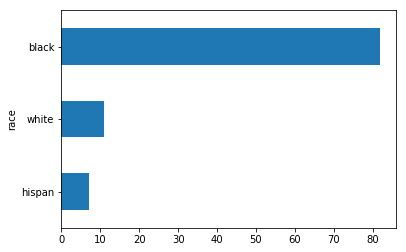

In [966]:
def plotCategories(df):
    categories = df.groupby(['race']).size()
    (categories.sort_values() / len(df) * 100).plot.barh()

plotCategories(treat)

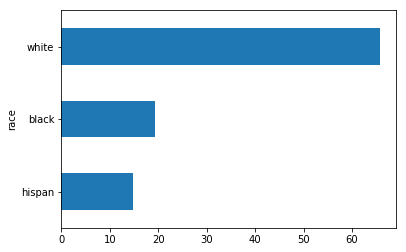

In [967]:
plotCategories(control)

We can repeat the analysis but this time we group subjects by race and education to rule out unobserved factors influencing the results (thus we assume that two individuals with the same race and education have the same social background). While for hispanics we do not have enough data points to conclude anything and for white people there seems to be no clear effect, it is evident that the training has been effective for black people. There are still unobserved covariates that might influence the results, such as the will of working harder of treated subjects.

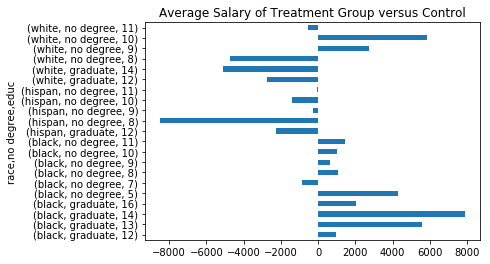

In [975]:
def diffOfSalaries(df0):
    df = df0[df0['re78'] > 0]
    treat = df[df['treat'] == 1].drop('treat', 1)
    control = df[df['treat'] == 0].drop('treat', 1)
    avgTreat = treat.groupby(['race', 'no degree', 'educ'])['re78']
    avgControl = control.groupby(['race', 'no degree', 'educ'])['re78']
    (avgTreat.mean() - avgControl.mean()).dropna().plot.barh(title="Average Salary of Treatment Group versus Control")

diffOfSalaries(df0)

## 3. A propensity score model

In [998]:
def buildTraining(df):
    x = df.copy()
    x['married'] = x['married'].map(lambda x: 0 if x == 'bachelor' else 1)
    x['no degree'] = x['no degree'].map(lambda x: 0 if x == 'graduate' else 1)
    x['race'] = x['race'].map(lambda x: ord(x[0]))
    return x

def compute_scores(df0):
    logistic = linear_model.LogisticRegression()
    train = buildTraining(df0.drop('treat', 1))
    logistic.fit(train, df0['treat'])
    return logistic.predict_proba(train)[:, 1]

## 4. Balancing the dataset via matching

It seems that now the control group has a higher salary average. The treatment group is unchanged. We observed that concerning lower salaries (< 2000) there is a clear effect of the job training program (treated subjects earn around 400 more on average). However, this is only a slight improvement over the previous results, since the analysis of categorical data shows data the propensity score did not weight enough the 'race' feature (the two groups are still biased), which is arguably the most relevant one. In contrast, it appears that the two groups are more dishomogeneous in terms of age and previous salaries.

In [1002]:
import networkx as matcher

def match(df0):
    # initialization
    scores = compute_scores(df0)
    control_scores = scores[df0['treat'] == 0]
    treat_scores = scores[df0['treat'] == 1]
    graph = matcher.complete_bipartite_graph(len(treat_scores), len(control_scores))
    d = {}

    # weight edges and compute matching
    for (u, v) in graph.edges():
        d[(u, v)] = abs(treat_scores[u] - control_scores[v - len(treat_scores)])
    matcher.set_edge_attributes(graph, 'weight', d)
    return matcher.max_weight_matching(graph)

pairs = match(df0)

In [993]:
# Restrict dataframe to matched subjects
def buildMatchedDF(df0, pairs):
    ls = np.empty(len(df0), dtype='a16')
    ls[:] = np.nan
    for u in pairs:
        ls[u] = df0.iloc[pairs[u]].name
    df0Match = df0.copy()
    df0Match['match'] = [x.decode('utf8') for x in ls ]
    return df0Match[df0Match['match'] != 'nan']

df0Match = buildMatchedDF(df0, pairs)

In [911]:
df = df0[df0['re78'] > 0]
treat = df[df['treat'] == 1]
control = df[df['treat'] == 0]
dfMatch = df0Match[df0Match['re78'] > 0].drop('match', 1)
treatMatch = dfMatch[dfMatch['treat'] == 1]
controlMatch = dfMatch[dfMatch['treat'] == 0]

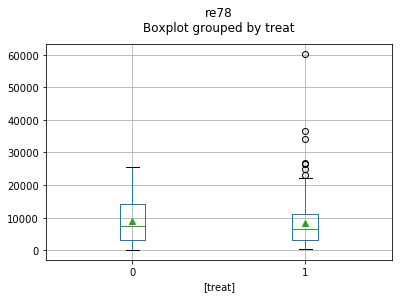

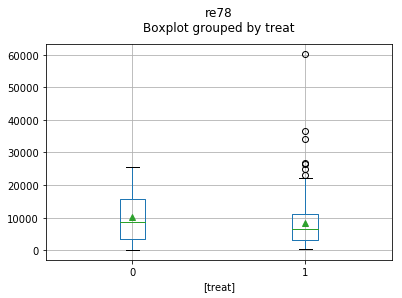

In [912]:
# Comparison of old plot vs new
boxplots(df, 're78')
boxplots(dfMatch, 're78')

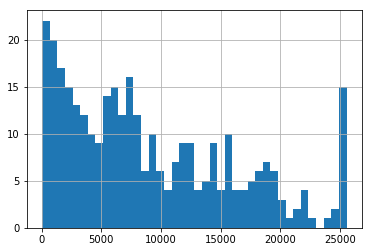

In [913]:
# The old histogram
control['re78'].hist(bins=40)

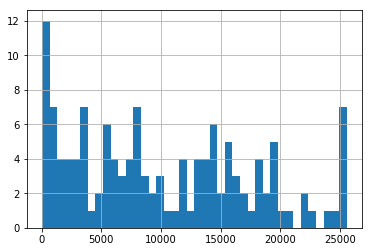

In [914]:
controlMatch['re78'].hist(bins=40)

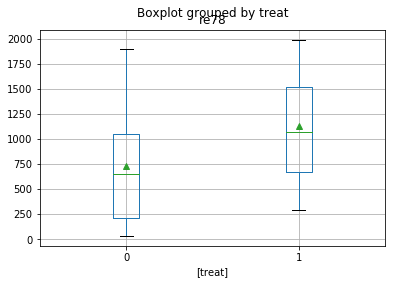

In [917]:
# An effect of the treatment is shown only when limiting the salaries to a lower range
dfMatch[dfMatch['re78'] < 2000][['treat', 're78']].boxplot(by='treat', showmeans=True)

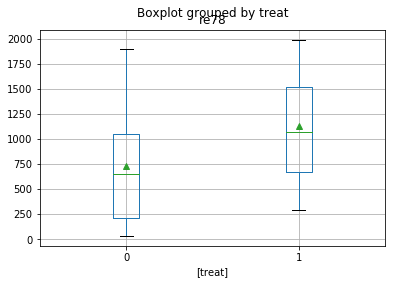

In [923]:
# An effect of the treatment is shown only when limiting the salaries to a lower range
dfMatch[(dfMatch['re78'] < 2000)][['treat', 're78']].boxplot(by='treat', showmeans=True)

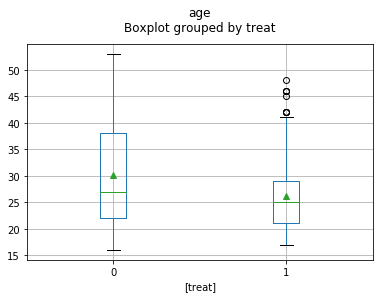

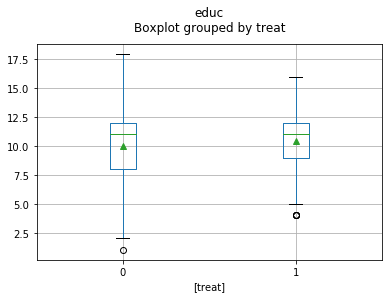

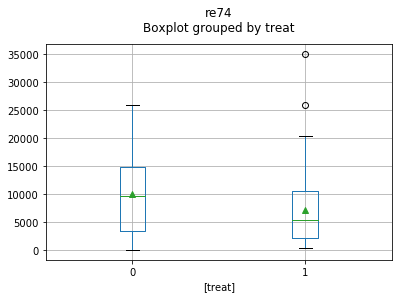

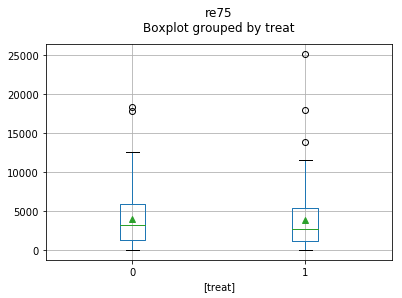

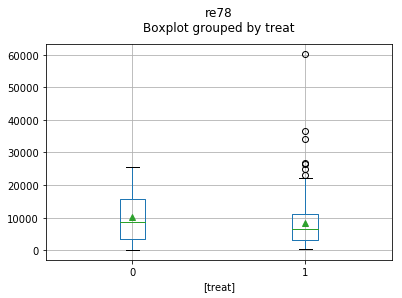

In [950]:
dfMatch = df0Match[['treat', 'age', 'educ', 're74', 're75', 're78']]
treat = dfMatch[dfMatch['treat'] == 1].drop('treat', 1)
control = dfMatch[dfMatch['treat'] == 0].drop('treat', 1)
for col in dfMatch.drop(['treat'], 1).columns:
    boxplots(dfMatch, col)

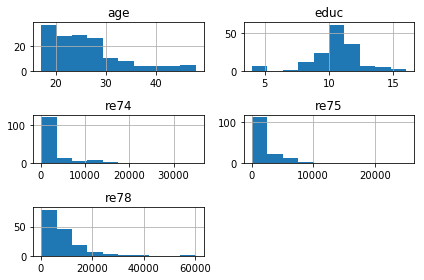

In [935]:
treat.hist()
plt.tight_layout()

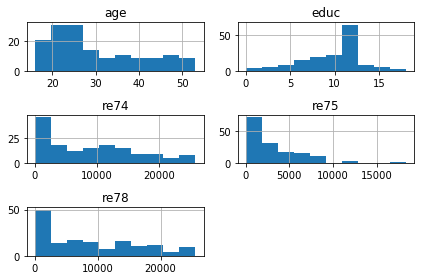

In [933]:
control.hist()
plt.tight_layout()

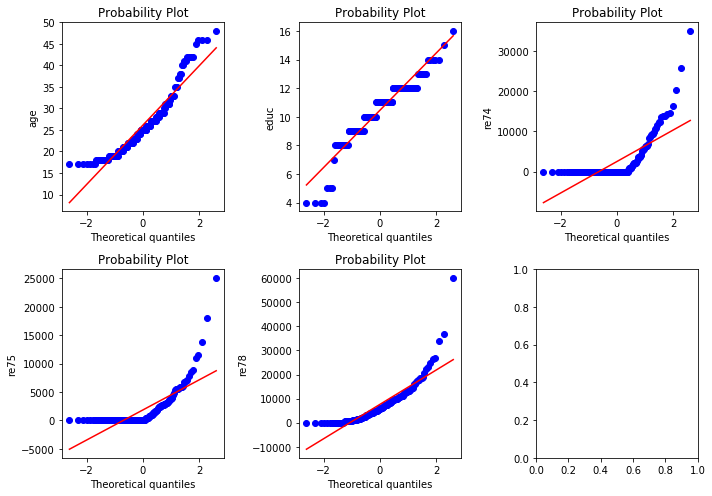

In [938]:
qqPlots(treat)

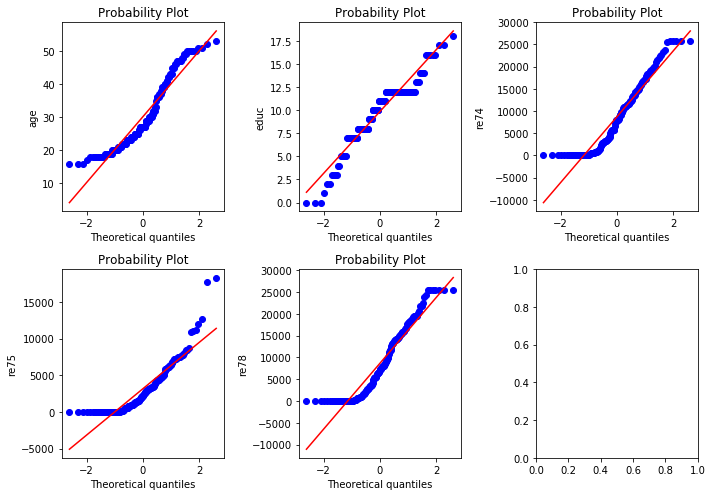

In [937]:
qqPlots(control)

In [945]:
dfMatch = df0Match[['treat', 'race', 'married', 'no degree']]
treat = dfMatch[dfMatch['treat'] == 1].drop('treat', 1)
control = dfMatch[dfMatch['treat'] == 0].drop('treat', 1)

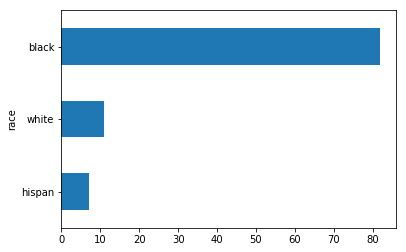

In [946]:
plotCategories(treat)

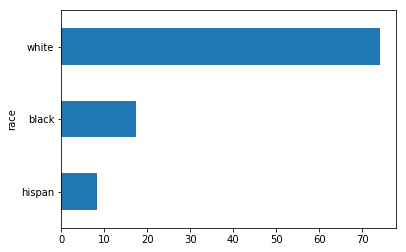

In [947]:
plotCategories(control)

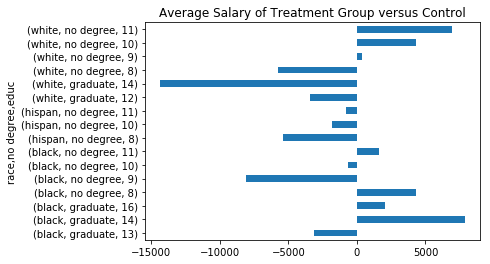

In [976]:
diffOfSalaries(df0Match)

## 5. Balancing the groups further

To solve the issue, we split the original dataframe by race and then perform the same matching again.

In [990]:
df0B = df0[df0['race'] == 'black']
df0H = df0[df0['race'] == 'hispan']
df0W = df0[df0['race'] == 'white']

In [ ]:
# Matches are slow so we keep them stored
# Test this!
df0BMatch = match(df0B)
df0HMatch = match(df0H)
df0WMatch = match(df0W)

In [1003]:
df0BMatched = buildMatchedDF(df0B, df0BMatch)
df0HMatched = buildMatchedDF(df0H, df0HMatch)
df0WMatched = buildMatchedDF(df0W, df0WMatch)

In [1004]:
df0BMatched

,treat,age,educ,married,re74,re75,re78,no degree,race,match
id,,,,,,,,,,
NSW1,1,37,11,married,0.0000,0.0,9930.04600,no degree,black,PSID48
NSW3,1,30,12,bachelor,0.0000,0.0,24909.45000,graduate,black,PSID99
NSW4,1,27,11,bachelor,0.0000,0.0,7506.14600,no degree,black,PSID46
NSW8,1,32,11,bachelor,0.0000,0.0,8472.15800,no degree,black,PSID278
NSW9,1,22,16,bachelor,0.0000,0.0,2164.02200,graduate,black,PSID218
NSW12,1,21,13,bachelor,0.0000,0.0,17094.64000,graduate,black,PSID420
NSW14,1,27,10,married,0.0000,0.0,18739.93000,no degree,black,PSID398
NSW15,1,17,7,bachelor,0.0000,0.0,3023.87900,no degree,black,PSID189
NSW17,1,27,13,bachelor,0.0000,0.0,14581.86000,graduate,black,PSID98
